In [1]:
import jax
print("JAX devices:", jax.devices())

JAX devices: [CpuDevice(id=0)]


In [2]:
import jax.numpy as jnp
import numpy as np

#from ripple.waveforms import IMRPhenomD
from ripple import ms_to_Mc_eta

In [3]:
def select_waveform(waveform_name):
    """
    Imports and returns the specified waveform from ripple.waveforms.

    Parameters:
    waveform_name (str): The name of the waveform to import.

    Returns:
    class: The waveform class from ripple.waveforms.
    """
    try:
        # Import inside the function
        waveform_module = __import__('ripple.waveforms', fromlist=[waveform_name])
        mod_ = getattr(waveform_module, waveform_name)
        attr_ = "gen_"+waveform_name+"_hphc"
        return getattr(mod_, attr_)
    except AttributeError:
        raise ValueError(f"Waveform '{waveform_name}' not found in ripple.waveforms module.")

# Example usage:
# waveform = select_waveform("IMRPhenomD")


In [4]:
waveform_name = "IMRPhenomD"
waveform_module = __import__('ripple.waveforms', fromlist=[waveform_name])
test = getattr(waveform_module, waveform_name)
attr = "gen_"+waveform_name+"_hphc"
test2 = getattr(test, attr )

In [5]:
gen_hphc?

Object `gen_hphc` not found.


In [6]:
gen_hphc = select_waveform('IMRPhenomD')

In [7]:
import jax

@jax.jit
def waveform(fs, theta, f_ref=20):
    
    hp,hc = [], []
    for i in range(theta.shape[0]):

        hf = gen_hphc(fs[i], theta[i, :], f_ref)
        # hp.append(jnp.sum(hf[0]))
        # hc.append(jnp.sum(hf[1]))
        hp.append(hf[0])
        hc.append(hf[1])

    return jnp.array(hp), jnp.array(hc)

# def waveform(fs, theta, f_ref=20):
    
#     hp,hc = [], []
#     for i in range(theta.shape[0]):

#         hf = gen_hphc(fs[i], theta[i, :], f_ref)
#         hp.append(hf[0])
#         hc.append(hf[1])

#     return np.array(hp), np.array(hc)

* let's try vmap

In [60]:
@jax.jit
def waveform(fs, theta):
    f_ref=20
    hf = gen_hphc(fs, theta, f_ref)
    return hf[0], hf[1]

In [69]:
from jax import vmap
# use vmap instead of looping
vmap_waveform = jax.vmap(waveform)

In [73]:
hp, hc = vmap_waveform(fs, theta_ripple)

In [63]:
hp.shape, hc.shape

((20, 8112), (20, 8112))

In [64]:
hp, hc = np.array(hp), np.array(hc)

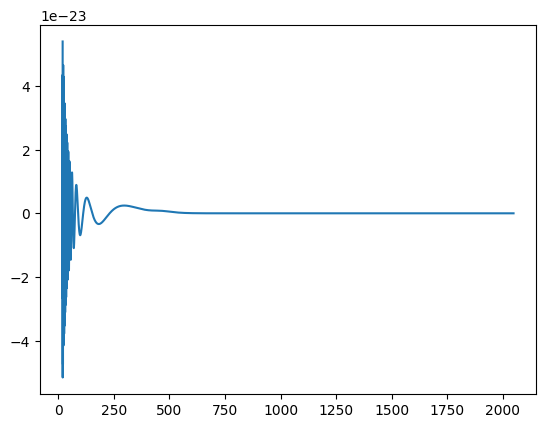

In [66]:
import matplotlib.pyplot as plt
# abs(hp[0]), fs
plt.plot(fs[10], np.real(hp[10]))
plt.show()

In [33]:
from jax import vmap

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

print(convolve(x, w))

# Suppose we would like to apply this function to a batch of
# weights w to a batch of vectors x.
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

# use vmap instead of looping
auto_batch_convolve = vmap(convolve)

print(auto_batch_convolve(xs, ws))

[11. 20. 29.]
[[11. 20. 29.]
 [11. 20. 29.]]


Array([0, 1, 2, 3, 4], dtype=int32)

Array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]], dtype=int32)

In [68]:
size_ = 100000
m1_msun = 20.0*np.ones(size_) # In solar masses
m2_msun = 19.0*np.ones(size_)
chi1 = 0.5*np.ones(size_) # Dimensionless spin
chi2 = -0.5*np.ones(size_)
# lambda1 = 0.0*np.ones(size_) # Dimensionless tidal deformability
# lambda2 = 0.0*np.ones(size_) # Dimensionless tidal deformability
tc = 0.0*np.ones(size_) # Time of coalescence in seconds
phic = 0.0*np.ones(size_) # Time of coalescence
dist_mpc = 440*np.ones(size_) # Distance to source in Mpc
inclination = 0.0*np.ones(size_) # Inclination Angle

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
duration = 4.0*np.ones(size_)
del_f = 1.0/duration
f_l = 20.0
f_u = 2048.0
fs = []
for df  in del_f:
    fs.append(np.arange(f_l, f_u, df))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination]).T

In [71]:
fs = jnp.array(fs)

In [72]:
fs.shape, theta_ripple.shape

((100000, 8112), (100000, 8))

In [59]:
hp, hc = waveform(fs, theta_ripple)

TypeError: waveform() takes 1 positional argument but 2 were given

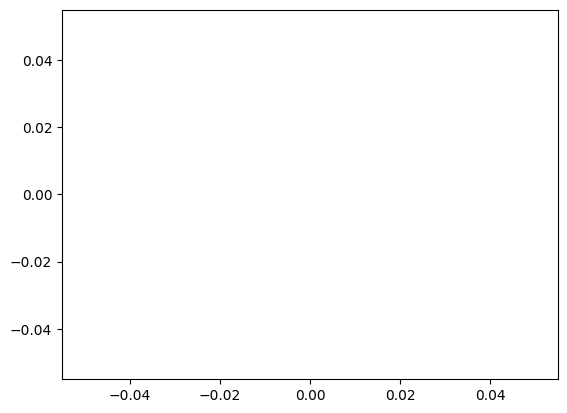

In [50]:
import matplotlib.pyplot as plt
# abs(hp[0]), fs
plt.plot(fs[10], np.real(hp[10]))
plt.show()

In [ ]:
## Create the function
def compute_ripple_snr(
    mass_1=10,
    mass_2=10,
    luminosity_distance=100.0,
    theta_jn=0.0,
    psi=0.0,
    phase=0.0,
    geocent_time=1246527224.169434,
    ra=0.0,
    dec=0.0,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,
    gw_param_dict=False,
    output_jsonfile=False,
):
    """
    """

    # if gw_param_dict is given, then use that
    if gw_param_dict is not False:
        mass_1 = gw_param_dict["mass_1"]
        mass_2 = gw_param_dict["mass_2"]
        luminosity_distance = gw_param_dict["luminosity_distance"]
        theta_jn = gw_param_dict["theta_jn"]
        psi = gw_param_dict["psi"]
        phase = gw_param_dict["phase"]
        geocent_time = gw_param_dict["geocent_time"]
        ra = gw_param_dict["ra"]
        dec = gw_param_dict["dec"]
        # a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl exist in the dictionary
        # if exists, then use that, else pass
        if "a_1" and "a_2" in gw_param_dict:
            a_1 = gw_param_dict["a_1"]
            a_2 = gw_param_dict["a_2"]
        if "tilt_1" and "tilt_2" and "phi_12" and "phi_jl" in gw_param_dict:
            tilt_1 = gw_param_dict["tilt_1"]
            tilt_2 = gw_param_dict["tilt_2"]
            phi_12 = gw_param_dict["phi_12"]
            phi_jl = gw_param_dict["phi_jl"]

    npool = self.npool
    sampling_frequency = self.sampling_frequency
    detectors = self.detector_list.copy()
    detector_tensor = np.array(self.detector_tensor_list.copy())
    approximant = self.waveform_approximant
    f_min = self.f_min
    num_det = np.arange(len(detectors), dtype=int)

    # get the psds for the required detectors
    psd_dict = {detectors[i]: self.psds_list[i] for i in num_det}

    # reshape(-1) is so that either a float value is given or the input is an numpy array
    # make sure all parameters are of same length
    mass_1, mass_2 = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1)
    num = len(mass_1)
    (
        mass_1,
        mass_2,
        luminosity_distance,
        theta_jn,
        psi,
        phase,
        geocent_time,
        ra,
        dec,
        a_1,
        a_2,
        tilt_1,
        tilt_2,
        phi_12,
        phi_jl,
    ) = np.broadcast_arrays(
        mass_1,
        mass_2,
        luminosity_distance,
        theta_jn,
        psi,
        phase,
        geocent_time,
        ra,
        dec,
        a_1,
        a_2,
        tilt_1,
        tilt_2,
        phi_12,
        phi_jl,
    )

    #################################################
    # setting up parameters for JAX multiprocessing #
    #################################################
    mtot = mass_1 + mass_2
    idx = (mtot >= self.mtot_min) & (mtot <= self.mtot_max)
    # size1 = np.sum(idx)

    # IMPORTANT: time duration calculation for each of the mass combination
    safety = 1.2
    approx_duration = safety * findchirp_chirptime(mass_1[idx], mass_2[idx], f_min)
    duration = np.ceil(approx_duration + 2.0)
    if self.duration_max:
        duration[duration > self.duration_max] = self.duration_max  # IMRPheonomXPHM has maximum duration of 371s

    # setting up the input arguments 
    Mc, eta = ms_to_Mc_eta(jnp.array([mass_1[idx], mass_2[idx]]))
    del_f = 1.0/duration
    fs = []
    for df  in del_f:
        fs.append(np.arange(f_l, f_u, df))

    input_arguments = jnp.array(
        [
            Mc,
            eta,
            a_1[idx],
            a_2[idx],
            luminosity_distance[idx],
            geocent_time[idx],
            phase[idx],
            theta_jn[idx],
        ],
    ).T

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
duration = 4.0*np.ones(size_)


    hp, hc = waveform(input_arguments)

In [50]:
Gamma = 0.5772156649015329
Pi = np.pi
MTSUN_SI = 4.925491025543576e-06

@jax.jit
def findchirp_chirptime(m1, m2, fmin=20.0):
    """
    Time taken from f_min to f_lso (last stable orbit). 3.5PN in fourier phase considered.

    Parameters
    ----------
    m1 : `float`
        Mass of the first body in solar masses.
    m2 : `float`
        Mass of the second body in solar masses.
    fmin : `float`
        Lower frequency cutoff.

    Returns
    -------
    chirp_time : float
        Time taken from f_min to f_lso (last stable orbit frequency).
    """

    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.0

    c7T = Pi * (
        14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0
    )

    c6T = (
        Gamma * 6848.0 / 105.0
        - 10052469856691.0 / 23471078400.0
        + Pi * Pi * 128.0 / 3.0
        + eta * (3147553127.0 / 3048192.0 - Pi * Pi * 451.0 / 12.0)
        - eta * eta * 15211.0 / 1728.0
        + eta * eta * eta * 25565.0 / 1296.0
        + eta * eta * eta * 25565.0 / 1296.0
        + jnp.log(4.0) * 6848.0 / 105.0
    )
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * Pi * eta / 3.0 - 7729.0 * Pi / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * Pi / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = jnp.power(Pi * m * MTSUN_SI * fmin, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.
    return (
        c0T
        * (
            1
            + c2T * x2T
            + c3T * x3T
            + c4T * x4T
            + c5T * x5T
            + (c6T + c6LogT * jnp.log(xT)) * x6T
            + c7T * x7T
        )
        / x8T
    )

In [51]:
findchirp_chirptime(m1_msun, m2_msun, 20.0)

Array([1.8412848, 1.8412848, 1.8412848, ..., 1.8412848, 1.8412848,
       1.8412848], dtype=float32)

In [54]:
from ripple.waveforms import IMRPhenomD

# Get a frequency domain waveform
# source parameters

m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.5 # Dimensionless spin
chi2 = -0.5
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle

# The PhenomD waveform model is parameterized with the chirp mass and symmetric mass ratio
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

# These are the parametrs that go into the waveform generator
# Note that JAX does not give index errors, so if you pass in the
# the wrong array it will behave strangely
theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination])

# Now we need to generate the frequency grid
f_l = 24
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)

# Note that we have not internally jitted the functions since this would
# introduce an annoying overhead each time the user evaluated the function with a different length frequency array
# We therefore recommend that the user jit the function themselves to accelerate evaluations. For example:

import jax

@jax.jit
def waveform(theta):
    return IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta)

In [55]:
hp_ripple

Array([ 4.3180034e-23+0.0000000e+00j,  4.3049809e-23+3.0538884e-24j,
        4.2704521e-23+6.0856099e-24j, ..., -1.4065979e-25+5.8124834e-25j,
       -1.4062667e-25+5.8113090e-25j, -1.4058921e-25+5.8101484e-25j],      dtype=complex64)